# Assignment 11: Model Selection, Regularized regression and final practice
## Learning goals 
This homework includes some repeated task and variations on model fitting, and model comparision, which should prepare you optimally for the final. 
The homework also introduces z-standardization and regularized (L2) regression. 
Try to solve the task in the homework independently, and prepare a cheat-sheet and a file with useful functions, such that you can complete this homework in 3 hrs or less. 

## Data set 
The file kaiser.csv contains a subset of data from the Child Health and Development Studies, which investigate a range of topics. One study considered all pregnancies between 1960 and 1967 among women in the Kaiser Foundation Health Plan in the San Francisco East Bay area. Here, we look at the predictor of birth weight of babies, measured in pounds, as well as the occurence of complications in the first 3 month. 

The data frame stored in babies.csv contains the variables: 
- gestation:    Gestation period (length of pregnancy) [days]
- parity:       1: child the first born 0: Child has older siblings 
- age:          Age of the mom at time of birth
- height:       Height of the baby [cm].
- weight:       Weight of the baby [pounds].  
- smoke:        Is the mom a smoker / non-smoker? 
- hospital:     Which hospital was the birth at? Oakland, SanFrancisco, WalnutCreek, SanJose, and Richmond.
- complication: Was there a complication within the first 3 month of pregnancy (0: No 1:Yes) 

## Preliminaries
Set up the environment by importing pandas, seaborn, numpy, scipy.optimize and matplotlib. 
Then add your multiple regression functions (multRegPredict,multRegLossRSS, multRegFit) from the last homeworks. 

To make it easier - we have done these things already! 

In [14]:
import matplotlib
import matplotlib.pyplot as plt 
import scipy.optimize as so
import seaborn as sns
import pandas as pd 
import numpy as np

In [15]:
def multRegPredict(b, D, xname):
    """Prediction function for multipel regression 

    Args:
        b (nd.array): Array of regression coefficients - first is intercept 
        D (pd.DataFrame): Pandas data frame with explanatory variables
        xname (list): List of strings with names of explanatory variables  

    Returns:
        yp (nd.array): Predicted y - values 
    """
    yp = np.ones(len(D.index))*b[0]        # Intercept 
    for i in range(len(xname)):          
        yp = yp + D[xname[i]]*b[i + 1]         # Add each regression value 
    return yp 

def multRegLossRSS(b, D, y, xname):
    """Loss function for OLS multiple regression 

    Args:
        b (nd.array): Array of regression coefficients - first is intercept 
        D (pd.DataFrame): Pandas data frame with explanatory variables
        y (ndarray): Dependent variable 
        xname (list): List of strings with names of explanatory variables  

    Returns:
        rss: Current loss
        grad: gradient of loss function in respect to parameters  
    """
    predY = multRegPredict(b, D, xname)
    res = y - predY
    rss = sum(res**2)
    grad = np.zeros(len(b))
    grad[0] = -2*np.sum(res)
    for i in range(len(xname)):
        grad[i + 1] = -2*np.sum(D[xname[i]]*res)
    return (rss, grad)

def multRegFit(D, y, xname = [], figure = 0, b0 = []):
    """Fits a multiple regression loss function 

    Args:
        D (pd.DataFrame): Pandas data frame with explanatory variables
        y (ndarray): Dependent variable 
        xname (list): List of strings with names of explanatory variables  
        figure (int): Plot figure? Defaults to 0.
        b0 (np.ndarray). Initial guess for the parameter vector

    Returns:
        R2: Fitted R2 value 
        b: Fitted 
    """
    k = len(xname) + 1
    if (len(b0)!= k):
        b0 = np.zeros((k, ))
    RES = so.minimize(multRegLossRSS, b0, args = (D, y, xname), jac = True)
    b = RES.x # Results
    res = y - np.mean(y)
    TSS = sum(res**2)
    RSS, deriv = multRegLossRSS(b, D, y, xname)
    R2 = 1 - RSS/TSS 
    if (k == 2 and figure == 1):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(D[xname[0]], y)
        xRange = [min(D[xname[0]]), max(D[xname[0]])]
        xp = np.arange(xRange[0], xRange[1], (xRange[1] - xRange[0])/50)
        yp = b[0] + b[1]*xp
        ax.plot(xp, yp, 'r-')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return (R2, b)

## Task 1: Multiple regression with discrete variables ( / 30 pts)
### Question 1.1 ( / 10pt)
Create a dummy variable for Smoker / Non-smoker. Set the value for “Smoker” to 1 and for “Non-smoker” to 0. Estimate a regression model with the dummy variable as a regressor *and birth weight as the response variable.* 

Report the value of the intercept and slope. What does the intercept and slope value indicate? 


In [16]:
# import data set
df = pd.read_csv("kaiser.csv")
df.columns

# create dummy variable
tmp = df["smoke"] == "smoker"
smokeDummy = np.double(tmp)
df["smokeDummy"] = smokeDummy

# estimate regression model w dummy as regressor, birth weight response, report intercept slope
R2, b = multRegFit(D = df, y = df["weight"], xname = ["smokeDummy"])
print("The intercept is", b[0])
print("The slope is", b[1])

The intercept is 7.688278175592857
The slope is -1.2083133727774817


The intercept indicates the mean of comparison group, or birth weight. The slope indicates the difference between comparison and coded groups, or difference between birth weight and smoke.

### Question 1.2 ( / 8pt)
Make a boxplot of hospital on the x-axis and birthweight on the y-axis (see HW2 for an example). Which hospital has the lowest overall birth weight?  

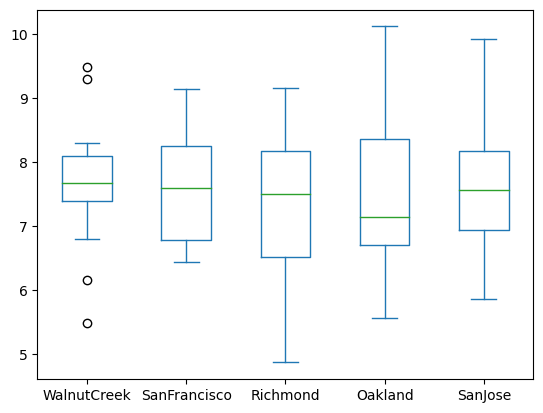

In [17]:
# group weight by hospital
group = df["weight"].groupby(df["hospital"])

# store weight stats by hospital
WC = group.get_group("WalnutCreek")
SF = group.get_group("SanFrancisco")
R = group.get_group("Richmond")
O = group.get_group("Oakland")
SJ = group.get_group("SanJose")

# put into another dataframe
data = {"WalnutCreek": WC, "SanFrancisco": SF, "Richmond": R, "Oakland": O, "SanJose": SJ}
newdf = pd.DataFrame(data)

# plot new dataframe
newdf.plot(kind = "box")

plt.show()

Oakland has the lowest mean birth weight.

### Question 1.3  ( / 12pt)
Create a set of 4 dummy variables that together code the hospital. Set Walnut Creek to be your comparison group. Run a multiple regression model with the 4 dummy variables as explanatory variables. Report the interecept and slope values. What do the intercept and slope values mean? 

In [36]:
group = df["weight"].groupby(df["hospital"])

tmp2 = df["hospital"] == "SanFrancisco"
SF = np.double(tmp2)
df["SanFrancisco"] = SF

tmp3 = df["hospital"] == "Richmond"
R = np.double(tmp3)
df["Richmond"] = R

tmp4 = df["hospital"] == "Oakland"
O = np.double(tmp4)
df["Oakland"] = O

tmp5 = df["hospital"] == "SanJose"
SJ = np.double(tmp5)
df["SanJose"] = SJ

df

,age,smoke,hospital,gestation,parity,weight,complication,smokeDummy,WalnutCreek,SanFrancisco,Richmond,Oakland,SanJose,ageZ,gestationZ,parityZ,smokeDummyZ
0,28.945386,smoker,WalnutCreek,259.984898,1,6.154760,1,1.0,1.0,0.0,0.0,0.0,0.0,-0.057013,-0.823657,1.484435,2.279803
1,37.369146,non-smoker,SanFrancisco,279.583370,0,6.746684,1,0.0,0.0,1.0,0.0,0.0,0.0,1.094299,0.615303,-0.666920,-0.434248
2,34.932707,non-smoker,Richmond,287.107287,0,9.150785,0,0.0,0.0,0.0,1.0,0.0,0.0,0.761300,1.167725,-0.666920,-0.434248
3,34.791652,non-smoker,Oakland,270.374191,0,7.023815,0,0.0,0.0,0.0,0.0,1.0,0.0,0.742021,-0.060854,-0.666920,-0.434248
4,41.950210,non-smoker,SanJose,245.130005,0,5.861300,0,0.0,0.0,0.0,0.0,0.0,1.0,1.720412,-1.914335,-0.666920,-0.434248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,17.535064,smoker,Richmond,264.054332,1,6.816188,1,1.0,0.0,0.0,1.0,0.0,0.0,-1.616510,-0.524871,1.484435,2.279803
96,36.919301,non-smoker,Richmond,249.503172,0,6.355362,0,0.0,0.0,0.0,1.0,0.0,0.0,1.032816,-1.593248,-0.666920,-0.434248
97,29.618348,smoker,Richmond,264.715985,1,6.102431,0,1.0,0.0,0.0,1.0,0.0,0.0,0.034964,-0.476291,1.484435,2.279803
98,22.833492,non-smoker,SanJose,288.755560,0,6.926468,1,0.0,0.0,0.0,0.0,0.0,1.0,-0.892351,1.288745,-0.666920,-0.434248


In [19]:
# multiple regression with 4 dummy variables as explanatory variables, report intercept and slope
R2, b = multRegFit(D = df, y = df["weight"], xname = ["SanFrancisco", "Richmond", "Oakland", "SanJose"])
b
# b0 is intercept is mean weight for WC

array([ 7.64577979,  0.02134188, -0.33250686, -0.2043533 , -0.10127978])

The intercept indicates the mean of comparison group, or birth weight for Walnut Creek hospital. The slope indicates the difference between comparison and coded groups, or difference between birth weight and smoke.

## Task 2: Model selection for multiple regression  ( / 35 pts)
### Question 2.1 ( / 20 pts)
Write a version of the crossvalidation function that does K-fold crossvalidation and works specifically with multRegFit as the fitting function. 

KfoldCVmultReg(D,y,xname,K=20,fitfcn=multRegFit,param={},predictfcn=multRegPredict):
- D: Data Frame with explanatory variables  
- y: response variable 
- xname: List of explanatory variables
- K: Number of crossvalidation folds

For dividing the data up in K pieces, you can use the following trick to assign a partition index to each of the data-points:
```
#N = number of data points 
#K = number of test sets (folds)
ind = np.arange(N)
ind = np.floor(ind/N*K)
```


The code should compute and return the crossvalidated R2 and the fitted R2. 
It should use the entries in the Dictionary to pass them to the function using `fitfcn(D,y,xname,**param)`
Run 20-fold crossvalidation on the multiple regression model, with birth weight as the response variable and 

- age of the mother 
- smoker (dummy coded) 
- birth occurred in Oakland? 
- gestation 

as explanatory variables. 
Report R2cv and R2. 

In [43]:
def KfoldCVmultReg(D,y,xname,K=20,fitfcn=multRegFit, param={},predictfcn=multRegPredict):
    N = len(y)
    yp = np.zeros(N)
    ind = np.arange(N)
    ind = (np.floor(ind/N*K))
    R2, b = fitfcn(D, y, xname)
    
    for i in range(K):
        train = ind != i   # this is training set
        test = ind == i    # this is test set
        r, b = fitfcn(D[train], y[train], xname)
        yp[test] = predictfcn(b, D[test], xname)  
    
    # calculate R-squared after cross validation
    TSS  = sum((y - y.mean())**2)
    RSScv = sum((y - yp)**2)
    R2cv = 1 - RSScv/TSS

    return (R2cv, R2)

# call function
KfoldCVmultReg(df, df["weight"], ["age", "smokeDummy", "Oakland", "gestation"])

(0.2789972631727561, 0.3560741562766846)

R-squared cross-validated = 0.279, R-squared = 0.356

### Question 2.2 ( / 15 pts)
Using the R2cv from the 20-fold crossvalidation, determine the best predictive model for birthweight using the following candidate variables 

- age of mom
- smoker (dummy coded) 
- gestation 
- parity 

Start with the R2cv for the full model (Question 2.1)and use backwards step-wise regression to find the best model (the model that increases R2cv the most). Show all steps of your selection procedure. Report the formula of your best model. 

In [52]:
# backwards step-wise regression
## start w full model
R2cv_full, R2 = KfoldCVmultReg(df, df["weight"], ["age", "smokeDummy", "gestation", "parity"])
print(R2cv_full)

## drop each explanatory variable
R2cv_age, R2 = KfoldCVmultReg(df, df["weight"], ["smokeDummy", "gestation", "parity"])
R2cv_smoke, R2 = KfoldCVmultReg(df, df["weight"], ["age", "gestation", "parity"])
R2cv_gest, R2 = KfoldCVmultReg(df, df["weight"], ["age", "smokeDummy", "parity"])
R2cv_parity, R2 = KfoldCVmultReg(df, df["weight"], ["age", "smokeDummy", "gestation"])

## is the full model greater? If yes, return full model R2, otherwise, keep going
print(R2cv_age)     # increases R2cv the most
print(R2cv_smoke)
print(R2cv_gest)
print(R2cv_parity)

# formula
R2, b = multRegFit(D = df, y = df["weight"], xname = ["smokeDummy", "gestation", "parity"])
R2, b

0.288195732076047
0.2950220643638243
0.16258030954795244
0.12824437772010555
0.2936324987336909


(0.3423345966737995,
 array([-1.1525801 , -1.01112725,  0.03236483,  0.10280571]))

The best model is y = -1.15 + -1.011x1 + 0.0324x2 + 0.103x3

## Task 3: Implement regularilzed regression to build a better predictive model (/35pts)
In this task you will implement regularized regression to try to build a better predictive model for the birthweight of data. 
Like in Task 2, we will consider the following explanatory variables:

- age of the mother 
- smoker (dummy coded) 
- birth occurred in Oakland? 
- gestation 

### Question 3.1: Z-standardize the regressors (/8pts)
Write a function `zstandardize`, which takes as an input a pandas series or ndarray 
and returns a z-standardized version of the data 

Use the function to z-standardize the columns age,gestation,parity, and smokeDummy. 

Create new columns in the data frame called ageZ,gestationZ,parityZ, and smokeDummyZ.

Check that the mean of the new variables in very close to and the std very close to 1.  

In [28]:
# create dummy variable
tmp = df["smoke"] == "smoker"
smokeDummy = np.double(tmp)
df["smokeDummy"] = smokeDummy

def zstandardize(var):
    # subtract mean, divide by standard deviation
    standardized = (var - var.mean())/(var.std())
    return standardized
        
# function call
ageZ = zstandardize(df["age"])
gestationZ = zstandardize(df["gestation"])
parityZ = zstandardize(df["parity"])
smokeDummyZ = zstandardize(df["smokeDummy"])
       
# add into df
df["ageZ"] = ageZ
df["gestationZ"] = gestationZ
df["parityZ"] = parityZ
df["smokeDummyZ"] = smokeDummyZ

# check that mean of new variables is close to 1
display(df.head())

,age,smoke,hospital,gestation,parity,weight,complication,smokeDummy,WalnutCreek,SanFrancisco,Richmond,Oakland,SanJose,ageZ,gestationZ,parityZ,smokeDummyZ
0,28.945386,smoker,WalnutCreek,259.984898,1,6.154760,1,1.0,1.0,0.0,0.0,0.0,0.0,-0.057013,-0.823657,1.484435,2.279803
1,37.369146,non-smoker,SanFrancisco,279.583370,0,6.746684,1,0.0,0.0,1.0,0.0,0.0,0.0,1.094299,0.615303,-0.666920,-0.434248
2,34.932707,non-smoker,Richmond,287.107287,0,9.150785,0,0.0,0.0,0.0,1.0,0.0,0.0,0.761300,1.167725,-0.666920,-0.434248
3,34.791652,non-smoker,Oakland,270.374191,0,7.023815,0,0.0,0.0,0.0,0.0,1.0,0.0,0.742021,-0.060854,-0.666920,-0.434248
4,41.950210,non-smoker,SanJose,245.130005,0,5.861300,0,0.0,0.0,0.0,0.0,0.0,1.0,1.720412,-1.914335,-0.666920,-0.434248


### Question 3.2 Implement Ridge regression (L2 regularized regression) (/17pts)

To implement ridge regression you need to modify two functions, the most important being the loss function. 
Make a copy of the function `multRegLossRSS` from assigment 10. 
Rename it to `ridgeLoss`. Give the function an additional input parameter, namely alpha. Give this a default value of 1.0. 

Change the loss and the gradient to take into account the regularization. 

**Note that we are not regularizing the intercept regressor (b0)**

Overall the function should take the following input arguments:

    Args:
        b (nd.array): Array of regression coefficients - first is intercept 
        D (pd.DataFrame): Pandas data frame with explanatory variables
        y (ndarray): Dependent variable 
        xname (list): List of strings with names of explanatory variables
        alpha (float): Regularization parameter 

    Returns:
        loss: Current loss
        grad: gradient of loss function in respect to parameters  

Then make a copy of `multRegFit` from the last homework and rename it to `ridgeFit`. 
Again, you need to add an additional input parameter (alpha) to the function. 
Alpha needs to be passed to your loss function (`ridgeLoss`) when you call so.minimize: 

`so.minimize(ridgeLoss,b0,args=(D,y,xname,alpha),jac=True)`

You need to take care when you calculate R2 of the fit - Since ridgeLoss does not return the 
residual-sum-of-squares, you need to use the appropriate function to calculate the RSS.

To test your function:
* Use it to fit a model that explains weight with the explanatory variables `['ageZ','smokeDummyZ','gestationZ','parityZ']`. Note: use the zstandardized version of the variables.  
* Do the fit setting `alpha=0` and `alpha=8`, and report both R2 and the regression coefficients (b)
* Compare the R2 between the two settings of alpha. Also compare to the one found for normal multiple regression (Question 2.1). What do you see and why?
* Compare the regression weights (b) between the two settings of alpha. which regression weights changed and why? 


In [29]:
# ridge regression loss function
# change loss and gradient to take into account regularization
def ridgeLoss(b, D, y, xname, alpha = 1.0):
    predY = multRegPredict(b, D, xname)
    res = y - predY
    rss = sum(res**2)
    grad = np.zeros(len(b))
    grad[0] = -2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1] = -2*np.sum(D[xname[i]]*res) + 2*alpha*b[i]
    loss = rss + alpha*np.sum(grad**2)
    return (loss, grad)

def ridgeFit(D, y, xname, alpha = 1.0):
    N = len(xname)
    b0 = np.zeros((N + 1,))
    RES = so.minimize(ridgeLoss, b0, args = (D, y, xname, alpha), jac=True)
    b = RES.x # Results
    loss = RES.fun
    yp = multRegPredict(b, df, xname)

    RSS = np.sum(loss**2)
    res = y - np.mean(y)
    TSS = sum(res**2)
    R2 = 1 - RSS/TSS 
    return (R2, b)

In [30]:
# weight explained by ageZ, smokeDummyZ, gestationZ, and parityZ, alpha = 0
ridgeFit(df, df["weight"], ["ageZ", "smokeDummyZ", "gestationZ", "parityZ"], alpha = 0)

(-45.712248855351156,
 array([ 7.49494802e+00, -1.04180250e-01, -3.82511915e-01,  4.33892437e-01,
         4.17899298e-03]))

In [31]:
# alpha = 8
ridgeFit(df, df["weight"], ["ageZ", "smokeDummyZ", "gestationZ", "parityZ"], alpha = 8)

(-124.02253050303534,
 array([ 7.49497447, -0.84778479, -0.37867761,  0.42293459, -0.33521225]))

alpha 8 should have a greater R-squared than alpha 0. This R-squared should also be higher than the R-squared from just using multiple regression.

All parameters except the intercept changed because it can't be regularized (can't be penalized).

### Question 3.3: Crossvalidate Ridge regression (10pts)
Copy your function `KfoldCVmultReg` from Question 2.1, rename it to `KfoldCVridge`, and modify it to work with Ridge regression. 
That means it needs to take an additional input parameter `alpha` that it passes on to the fitting function. 

To calculate the R2 and R2cv for the model of `weight` using the explanatory variables `['ageZ','smokeDummyZ','gestationZ','parityZ']`. Like in question 3.2, use the standardized versions of the variables and try both the setting `alpha=0` and `alpha=8`. 

How to the R2 and R2cv values compare between the two settings of alpha? Do you get better predictive performance than the reduced model that you found using feature selection (Question 2.2)?


*Note: If you want, play a bit with the regularization parameter to see if you can find a better setting. What happens when you make `alpha` very large (i.e. 1000)? (this is optional, but educational)*

In [50]:
def KfoldCVridge(D,y,xname,K=20,fitfcn=ridgeFit, param={},predictfcn=multRegPredict, alpha = 1):
    N = len(y)
    yp = np.zeros(N)
    ind = np.arange(N)
    ind = (np.floor(ind/N*K))
    R2, b = fitfcn(D, y, xname, alpha)
    
    for i in range(K):
        train = ind != i   # this is training set
        test = ind == i    # this is test set
        r, b = fitfcn(D[train], y[train], xname, alpha)
        yp[test] = predictfcn(b, D[test], xname)  
    
    # calculate R-squared after cross validation
    TSS  = sum((y - y.mean())**2)
    RSScv = sum((y - yp)**2)
    R2cv = 1 - RSScv/TSS

    return (R2cv, R2)

# call function alpha = 0
KfoldCVridge(df, df["weight"], ["ageZ", "smokeDummyZ", "gestationZ", "parityZ"])

(0.2805124550260887, -46.65060862211698)

In [51]:
# call function alpha = 8
KfoldCVridge(df, df["weight"], ["ageZ", "smokeDummyZ", "gestationZ", "parityZ"], alpha = 8)

(-0.22312810971694175, -124.02253050303534)

As alpha increases, both R-squared values should increase.
The predictive performance should be better than when using feature selection.

## Task 4: Use logistic regression to predict complications 
In this task you will create and test a logistic regression model that predicts the presence of a complication in the first three month (0: no complication, 1: complication). 

** Task 4 of the Homework does not have to be handed in and will not be graded! It is only added here to provide additional preparation and practice for you for the final. So if you are short on time, leave these questions open and solve them when you practice for the final.**

### Question 4.1: Improving your logistic regression model code
Improve your code for logisitic regression in two ways: 

1. prevent log(0) errors by making sure that your predicted value never is smaller than 1e-20 or larger than 1-1e-20. (tip you can use the numpy function `clip`)

2. Let logisticRegFit take an additional input parameter, telling it whether it should plot a figure or not (figure=1) 

3. Let logisticRegFit take an additional input parameter, specifying the starting value for the parameters (b0=[]). If b0 is empty, the function should start with a vector off all zeros. 

### Question 4.2: Crossvalidation of logistic models
Modify the KfoldCVmultReg function to make it work for logistic regression. As before, use K-fold crossvalidation. The main changes are that 
- you need to use logisticRegFit and logisticRegPredict as fitfcn and predictfcn respectively. 
- instead of the crossvalidated R2, your function should return the crossvalidated log-likelihood and non-crossvalidated log-likelihood. 

Using your function, calculate the the difference in crossvalidated log-likelihood for the model that predicts complications with an intercept only (b0) and a model that predicts complications with an intercept and smokeDummy. 
From the difference, report the Bayes-Factor between the two models. What do you conclude? 

### Question 4.3:
Compare the model that uses only smoking (and intercept) as explanatory variable to one that uses additionally (to intercept and smoking) the weight of the baby at birth, age of the mom, or both. Calculate crossvalidated Log-likelihood, which one is the best model? 

### Question 4.4 : 
In the model (['smokeDummy','weight']), how do each of the explanatory variables contribute to the chance of complication? That is, for each variable, would an increase an the variable lead to an increased or decreased probability of a complication? In terms of risk of complications, how many pounds of extra weight can make up for having a smoking mother?  